In [1]:
%reload_ext autoreload
%autoreload 2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display
from ipywidgets import widgets, interactive

from scipy.io import mmread

from typing import List

## Prepare datasets if not exist

In [2]:
from util import download_all_data_if_not_exist, unzip

download_all_data_if_not_exist('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE156nnn/GSE156455/suppl', './datasets/gziped',filter=lambda file: file.endswith('.gz'))
unzip('./datasets/gziped/', './datasets')

File already exists: GSE156455_barcodes_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_barcodes_main.tsv.gz in ./datasets/gziped
File already exists: GSE156455_features_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_features_main.tsv.gz in ./datasets/gziped
File already exists: GSE156455_matrix_early.mtx.gz in ./datasets/gziped
File already exists: GSE156455_matrix_main.mtx.gz in ./datasets/gziped
File already exists: GSE156455_metadata_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_metadata_main.tsv.gz in ./datasets/gziped
File already exists: GSE156455_tsne_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_tsne_main.tsv.gz in ./datasets/gziped


## Toggle dataset type (early: 0\~24h, main: 24\~96h)

In [3]:
data_dir = "./datasets"
data_type = "early"

def show_widget_datatype_select():
  dropdown = widgets.Dropdown(options=["early", "main"], value="early", description="dataset:")

  def on_value_change(t: str):
    global data_type
    data_type = t

  interactive(on_value_change, t=dropdown)
  display(dropdown)

show_widget_datatype_select()

Dropdown(description='dataset:', options=('early', 'main'), value='early')

## Load dataset (reload required if you change dataset type)

In [4]:
path = lambda filename: os.path.join(data_dir, filename)

matrix_src = path(f"GSE156455_matrix_{data_type}.mtx")
feature_src = path(f"GSE156455_features_{data_type}.tsv")
barcode_src = path(f"GSE156455_barcodes_{data_type}.tsv")
metadata_src = path(f"GSE156455_metadata_{data_type}.tsv")
tsne_src = path(f"GSE156455_tsne_{data_type}.tsv")

# read in MEX format matrix as table
mat = mmread(matrix_src)

# feature_id:   transcript ids, e.g. 'FBgn0038498'
# feature_name: gene names,     e.g. 'beat-IIa'
# feature_type: feature types,  e.g. 'Gene Expression'
feature_df = pd.read_table(feature_src, names=['feature_id', 'feature_name', 'feature_type'])

# barcode:      cell ids        e.g. 'DGRP_All_A_2_TGATTTCGTCATCCGG'
barcode_df = pd.read_table(barcode_src, names=['barcode'])

# barcode:      cellID
# set:          W1118 or DGRP datasets
# rep:          biological replicate (A/B)
# trep:         technical replicate (i.e. a single 10X library, see sampleID format below)
# genotype:     W1118 or DGRP strain (based on demultiplexing)
# time:         timepoint
# class:        cell class
# type_:        cell type or cluster identity
# subtype:      cell subtype (if not applicable, same as type)
metadata_df = pd.read_table(metadata_src)

# barcode:      cellID
# tsne_1:       tSNE 1
# tsne_2:       tSNE 2"
tsne_df = pd.read_table(tsne_src)

data = mat.toarray()
data.shape # (n_features, n_cells)

(17561, 28633)

## Plot cell clusters from t-SNE result

In [5]:
tsne_with_metadata = pd.merge(tsne_df, metadata_df, on='barcode')

types = tsne_with_metadata['type'].unique()

centers = tsne_with_metadata.groupby('type').mean()[['tSNE_1', 'tSNE_2']]

/var/folders/w7/rrcz7y056_q_zqnsld3kmr580000gn/T/ipykernel_60676/335324791.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centers = tsne_with_metadata.groupby('type').mean()[['tSNE_1', 'tSNE_2']]


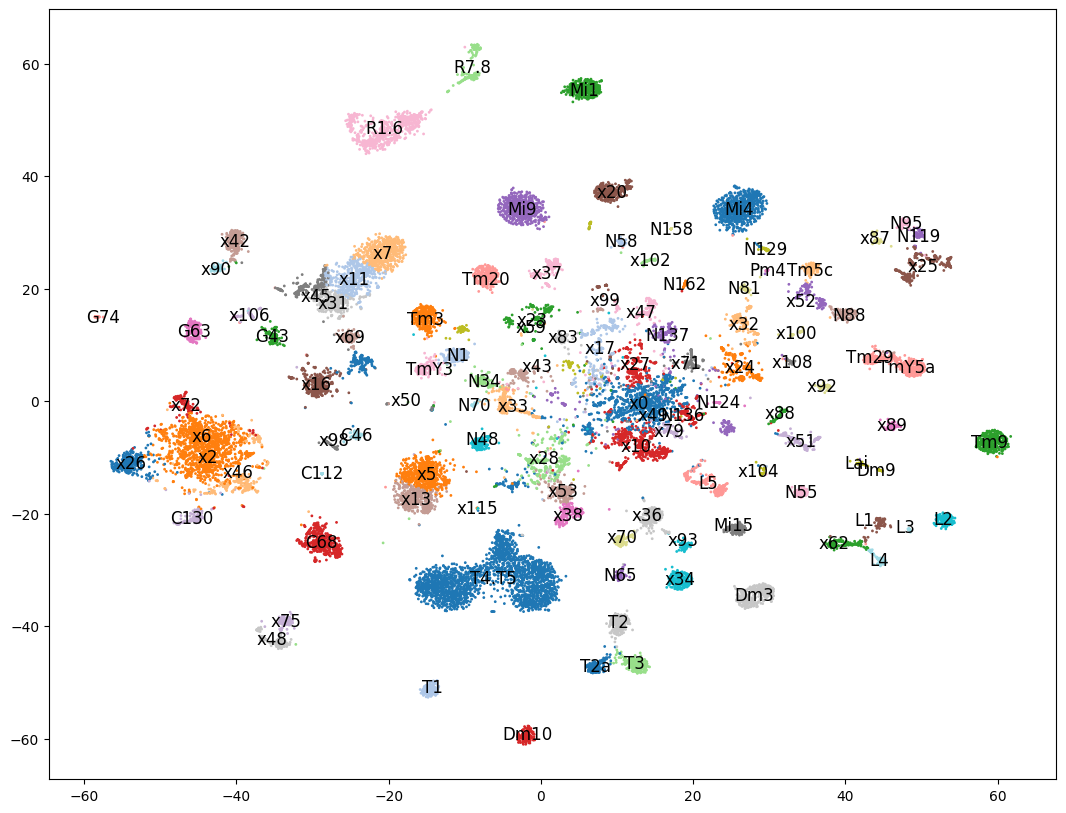

In [6]:
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)

cmap = cm.get_cmap('tab20', len(types))
cdict = {t: cmap(i) for i, t in enumerate(types)}
c = [cdict[t] for t in tsne_with_metadata['type']]

ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c=c)
for t, (tsne1, tsne2) in centers.iterrows():
    ax.annotate(t, (tsne2, tsne1), ha='center', va='center', fontsize=12)

## Plot expression level of specific gene in clusters

In [7]:
class PlotConfig:
    target_features = ["side-IV", "beat-IIb"]
    target_times = ["0h", "12h"]

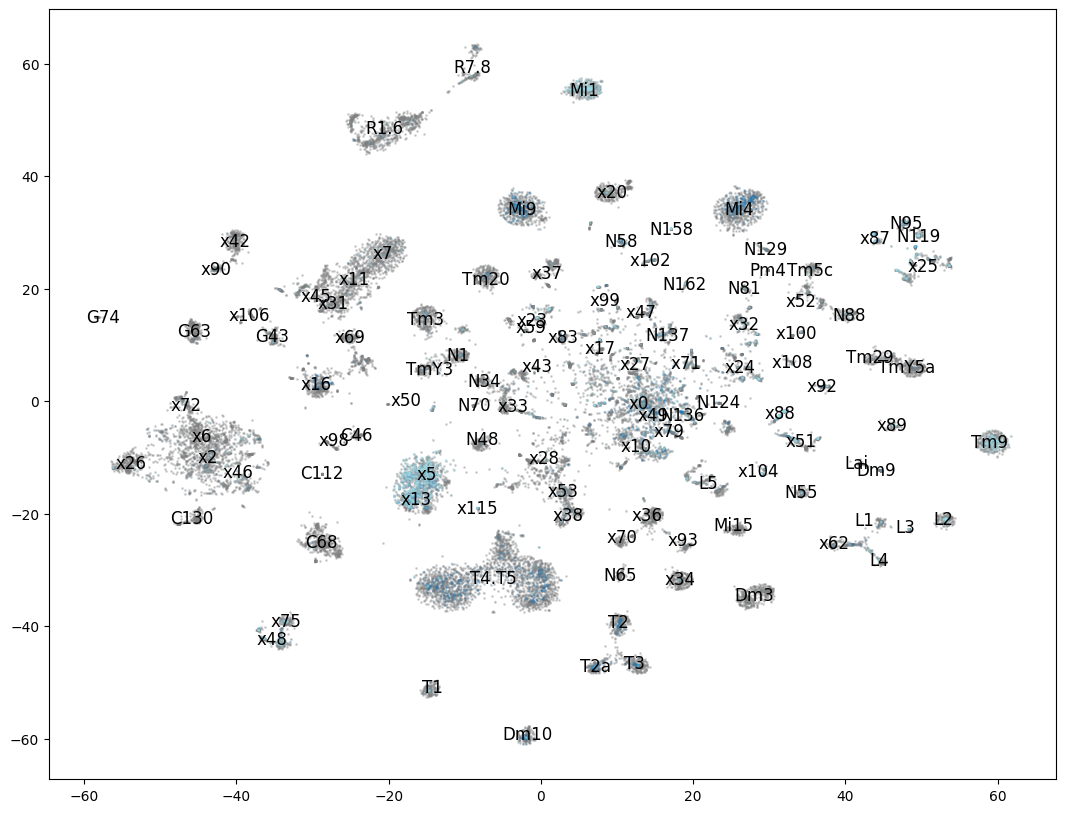

In [8]:
def show_plot(c: PlotConfig):
        fig = plt.figure(figsize=(13, 10))
        ax = fig.add_subplot(111)

        feature_filter = feature_df['feature_name'].isin(c.target_features)
        cell_filter = metadata_df['time'].isin(c.target_times)

        expressions = data[feature_filter].astype(np.double)
        expressions = expressions[:, cell_filter]

        tsne = tsne_with_metadata[cell_filter]

        n_features = len(c.target_features)
        # normalize
        for row in range(n_features):
            expressions[row] = np.log2(1 + expressions[row] / expressions[row].max())

        # base plot
        ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c='gray', alpha=0.3)
        for t, (tsne1, tsne2) in centers.iterrows():
            ax.annotate(t, (tsne2, tsne1), ha='center', va='center', fontsize=12)

        cmap = cm.get_cmap('tab20', n_features)
        for i, feature_name in enumerate(c.target_features):
            expression_filter = expressions[i] > 0

            filtered = tsne[expression_filter]
            ax.scatter(filtered['tSNE_2'], filtered['tSNE_1'], s=1, color=cmap(i), alpha=expressions[i][expression_filter])

show_plot(PlotConfig())

## List up genes which has similar expression pattern with target gene

In [39]:
class ListConfig:
  target_feature = "side-IV"
  target_cell_types = []
  target_times = ["0h", "12h", "24h"]
  expression_percentile = 10 # indicated by the red line in the plot
  theta_percentile = 5 # indicated by the green line in the plot
  output_dir = "output"

  def __init__(self) -> None:
    target_times = self.target_times.sort()

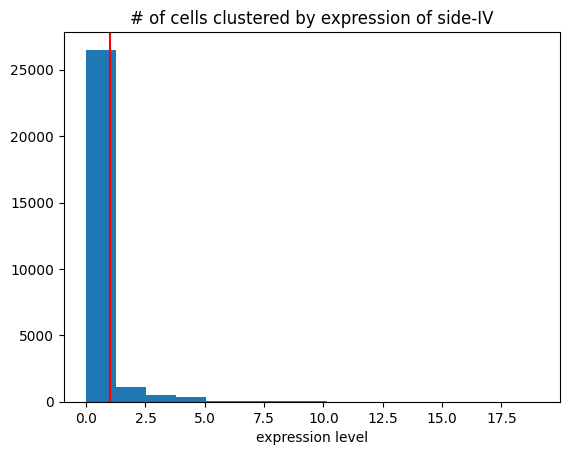

In [10]:
def show_expression_bar_plot(c: ListConfig):
  fig = plt.figure()
  ax = fig.add_subplot(111)

  expressions = data[feature_df['feature_name'] == c.target_feature].astype(np.double)[0]

  K = int(1 + np.log2(len(expressions)))

  ax.hist(expressions, bins=K)
  ax.set_title(f"# of cells clustered by expression of {c.target_feature}")
  ax.set_xlabel("expression level")

  ax.vlines(np.percentile(expressions, 100 - c.expression_percentile), 0, 1, colors=['red'], transform=ax.get_xaxis_transform());

show_expression_bar_plot(ListConfig())

In [11]:
def linear_regression(X: np.ndarray, y: np.ndarray):
  return np.linalg.pinv(X) @ y

In [20]:
def calc_theta(c: ListConfig):
  expressions = data[feature_df['feature_name'] == c.target_feature].astype(np.double)[0]

  threshold = np.percentile(expressions, 100 - c.expression_percentile)

  cell_filter = expressions > threshold
  if len(c.target_cell_types) != 0:
    cell_filter &= metadata_df['type'].isin(c.target_cell_types)
  if len(c.target_times) !=0:
    cell_filter &= metadata_df['time'].isin(c.target_times)

  X = data[:, cell_filter].T
  y = expressions[cell_filter]

  return linear_regression(X, y)

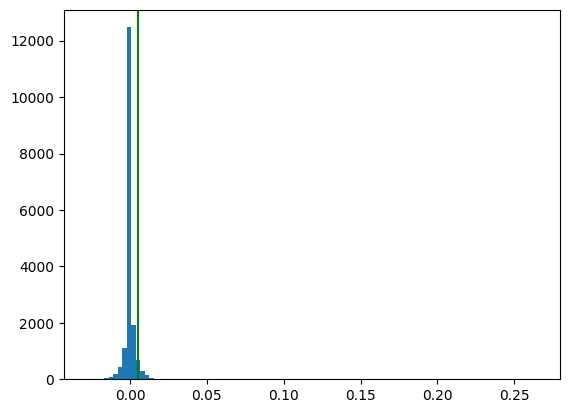

In [21]:
def show_corelation_bar_plot(c: ListConfig):
  fig = plt.figure()
  ax = fig.add_subplot(111)

  theta = calc_theta(c)

  # K = int(1 + np.log2(len(theta)))
  K = 100

  threshold = np.percentile(theta, 100 - c.theta_percentile)
  
  ax.hist(theta, bins=K)
  ax.vlines(threshold, 0, 1, colors=['green'], transform=ax.get_xaxis_transform())

show_corelation_bar_plot(ListConfig())

In [26]:
def save_coexpressed_gene_list(c: ListConfig):
  theta = calc_theta(c)
  
  pd.merge(feature_df, pd.DataFrame(theta, columns=['theta']), left_index=True, right_index=True).sort_values(by='theta', ascending=False).head(50).to_csv(path.join(c.output_dir, f"coexpressed_gene_list({c.target_feature}).csv", index=False))

save_coexpressed_gene_list(ListConfig())

## Visualize expression pattern

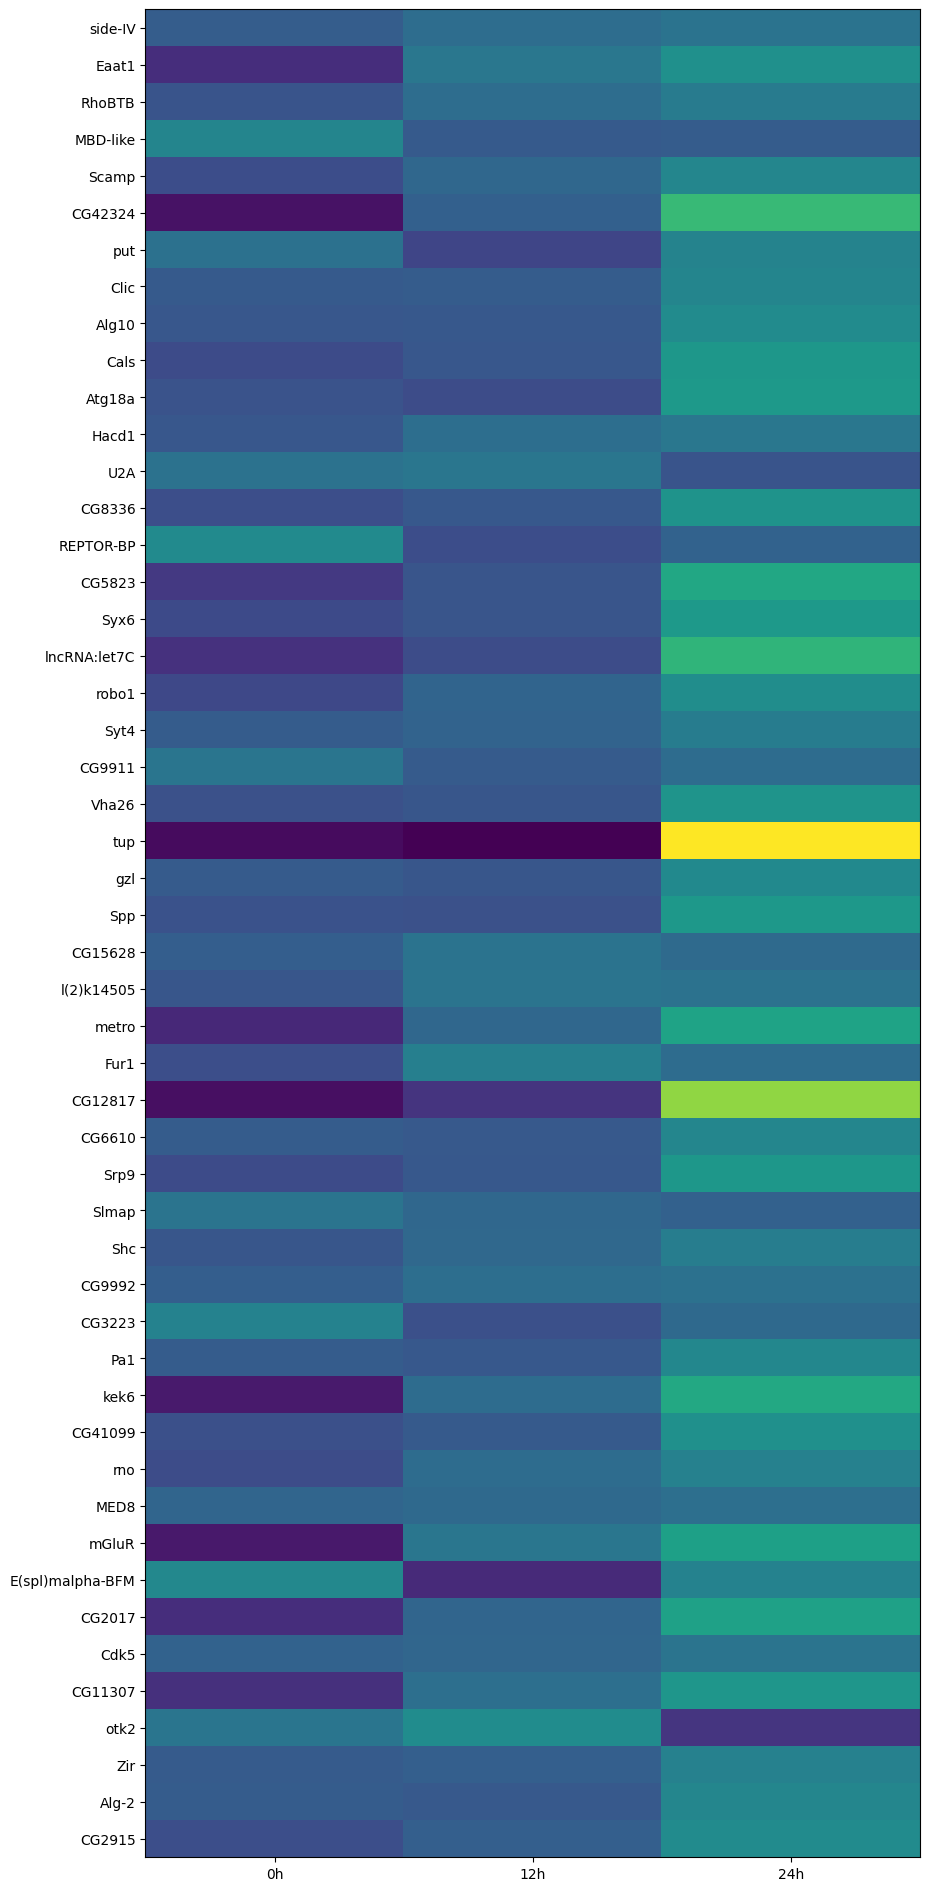

In [44]:
from sklearn.preprocessing import normalize

def save_expression_pattern_image(c: ListConfig):
  fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(10, 24))

  target_expressions = data[feature_df['feature_name'] == c.target_feature].astype(np.double)[0]

  threshold = np.percentile(target_expressions, 100 - c.expression_percentile)

  cell_filter = target_expressions > threshold
  if len(c.target_cell_types) != 0:
    cell_filter &= metadata_df['type'].isin(c.target_cell_types)
  if len(c.target_times) !=0:
    cell_filter &= metadata_df['time'].isin(c.target_times)

  expressions = np.zeros((len(feature_df), len(c.target_times)))

  for i, time in enumerate(c.target_times):
    time_filter = metadata_df['time'] == time
    expressions[:, i] = data[:, cell_filter & time_filter].mean(axis=1)

  expressions = normalize(expressions, axis=1, norm='l1')

  theta = calc_theta(c)

  coexpressed_features = pd.merge(feature_df, pd.DataFrame(theta, columns=['theta']), left_index=True, right_index=True)
  coexpressed_features = pd.merge(coexpressed_features, pd.DataFrame(expressions, columns=c.target_times), left_index=True, right_index=True)
  coexpressed_features = coexpressed_features.sort_values(by='theta', ascending=False).head(50)

  ax.set_xticks(np.arange(len(c.target_times)), labels=c.target_times)
  ax.set_yticks(np.arange(len(coexpressed_features)), labels=coexpressed_features['feature_name'])

  ax.imshow(coexpressed_features[c.target_times], aspect="auto") #type:ignore

  fig.savefig(path.join(c.output_dir ,f'{c.target_feature}.png'), dpi=100)

save_expression_pattern_image(ListConfig())